In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Missing vallue handling

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
## there is no missing value in this dataset

## Cleaning data

In [6]:
df['namestart']= df['nameDest'].apply(lambda x: str(x)[0])
df['nameend']= df['nameOrig'].apply(lambda x: str(x)[0])

In [7]:
merchant = df[df['namestart'] == 'M']
merchant['isFraud'].value_counts()

0    2151495
Name: isFraud, dtype: int64

In [8]:
## Nameend has no effect, because it only contain single data, 

In [9]:
len(df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)])

4116

In [10]:
len(df[(df['type'] == 'CASH_IN') & (df['isFraud'] == 1)])

0

In [11]:
len(df[(df['type'] == 'PAYMENT') & (df['isFraud'] == 1)])

0

In [12]:
len(df[(df['type'] == 'DEBIT') & (df['isFraud'] == 1)])

0

In [13]:
len(df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 1)])

4097

In [14]:
## CASH_IN,DEBIT and  PAYMENT has no effect on Fraud, so we replace it with 'REPLACE'
df['new_type'] = df['type'].replace({'CASH_IN':'REPLACE', 'DEBIT':'REPLACE', 'PAYMENT':'REPLACE'})
df['new_type'].value_counts()

REPLACE     3592211
CASH_OUT    2237500
TRANSFER     532909
Name: new_type, dtype: int64

### 2.1 Drop unwanted colums

In [15]:
df1 = df.copy()
df1 = df.drop(['type','nameOrig','nameend','nameDest','isFlaggedFraud'],axis=1)

## Split the data into independent and dependent 

In [16]:
#independent features 
x = df1.drop(['isFraud'],axis=1)

# dependent features 
y = df1['isFraud']

In [17]:
from imblearn.under_sampling import RandomUnderSampler

In [18]:
rus = RandomUnderSampler(random_state=42)

In [19]:
x_resampled,y_resampled = rus.fit_resample(x,y)

In [20]:
## concat the data
df2 = pd.concat([x_resampled,y_resampled],axis=1)


### 2.2 Remove unwanted step dataset

In [21]:
step_size = df2.step.value_counts().sort_values(ascending = True)
step_size_greater_than_10 = step_size[step_size>10]

In [22]:
df2['new_step'] = df2['step'].apply(lambda x: x if x in step_size_greater_than_10 else 1000) 

In [23]:
## only collect the data less than 1000 
df2 = df2[~(df2['new_step'] == 1000)]

###  2.4 Split the data into fraud and Non fraudd

In [24]:
fraud = df2[df2['isFraud'] == 1]
non_fraud = df2[df2['isFraud'] == 0]

In [25]:
fraud.shape,non_fraud.shape

((6411, 10), (8108, 10))

In [26]:
non_fraud_merchant = non_fraud[non_fraud['namestart'] == 'M']

In [27]:
non_fraud_customer = non_fraud[non_fraud['namestart'] == 'C']


### 2.5 details of data

In [28]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,new_step
count,6411.000000,6.411000e+03,6.411000e+03,6.411000e+03,6.411000e+03,6.411000e+03,6411.0,6411.000000
mean,355.848854,1.547275e+06,1.774892e+06,2.413147e+05,5.435011e+05,1.318753e+06,1.0,355.848854
std,211.711687,2.514771e+06,3.857621e+06,2.216045e+06,3.531242e+06,4.118892e+06,0.0,211.711687
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000
25%,178.000000,1.285233e+05,1.270547e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,178.000000
50%,350.000000,4.422902e+05,4.418735e+05,0.000000e+00,0.000000e+00,5.566140e+03,1.0,350.000000
75%,537.000000,1.636052e+06,1.636052e+06,0.000000e+00,1.479595e+05,1.075679e+06,1.0,537.000000
max,742.000000,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.0,742.000000


In [29]:
non_fraud_customer.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,new_step
count,5423.000000,5.423000e+03,5.423000e+03,5.423000e+03,5.423000e+03,5.423000e+03,5423.0,5423.000000
mean,240.230684,2.656046e+05,1.219670e+06,1.257756e+06,1.677502e+06,1.862838e+06,0.0,240.230684
std,140.066915,6.909658e+05,3.460336e+06,3.502506e+06,4.319164e+06,4.567808e+06,0.0,140.066915
min,1.000000,1.808000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.000000
25%,154.000000,7.723302e+04,0.000000e+00,0.000000e+00,1.462194e+05,2.283531e+05,0.0,154.000000
50%,236.000000,1.615979e+05,1.704500e+04,0.000000e+00,5.641803e+05,7.038101e+05,0.0,236.000000
75%,331.000000,2.789461e+05,1.750826e+05,2.634583e+05,1.710577e+06,1.924417e+06,0.0,331.000000
max,717.000000,3.147911e+07,3.280421e+07,3.285196e+07,1.667418e+08,1.680585e+08,0.0,717.000000


In [30]:
non_fraud_merchant.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,new_step
count,2685.000000,2685.000000,2.685000e+03,2.685000e+03,2685.0,2685.0,2685.0,2685.000000
mean,245.724022,13026.157233,7.117456e+04,6.454826e+04,0.0,0.0,0.0,245.724022
std,139.910889,12123.987627,1.433390e+05,1.406753e+05,0.0,0.0,0.0,139.910889
min,1.000000,0.600000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.000000
25%,157.000000,4380.780000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,157.000000
50%,250.000000,9700.160000,1.058182e+04,0.000000e+00,0.0,0.0,0.0,250.000000
75%,334.000000,17633.050000,6.895100e+04,5.668823e+04,0.0,0.0,0.0,334.000000
max,718.000000,90534.240000,1.371622e+06,1.356879e+06,0.0,0.0,0.0,718.000000


### 2.6 details of amount

In [31]:
fraud[fraud['amount']<128000].shape

(1597, 10)

In [32]:
non_fraud[non_fraud['amount']<4000].shape

(714, 10)

In [33]:
non_fraud[non_fraud['amount']>278000].shape

(1362, 10)

## Outleirs 

In [34]:
def find_boundaries(df,feature):
    Q1=df[feature].quantile(0.25)
    Q3=df[feature].quantile(0.75)
    Q1=Q1.astype(np.float32)
    Q3=Q3.astype(np.float32)
    
    IQR=Q3-Q1
    ### Outlier values
    lower_boundary=Q1-1.5*(IQR)
    upper_boundary=Q3+1.5*(IQR)
    
    return lower_boundary, upper_boundary

In [35]:
numerical_variables = ['amount']

In [36]:
## fraud 
fraud_lower_outlier_value,fraud_upper_outlier_value=find_boundaries(fraud,numerical_variables)

In [37]:
fraud_lower_outlier_value,fraud_upper_outlier_value

(amount   -2132770.0
 dtype: float32,
 amount    3897345.5
 dtype: float32)

In [38]:
## non fraud merchant
non_fraud_merchant_lower_outlier_value,non_fraud_merchant_upper_outlier_value = find_boundaries(non_fraud_merchant,numerical_variables)


In [39]:
non_fraud_merchant_lower_outlier_value,non_fraud_merchant_upper_outlier_value

(amount   -15497.626953
 dtype: float32,
 amount    37511.457031
 dtype: float32)

In [40]:
## non fraud customer
non_fraud_customer_lower_outlier_value,non_fraud_customer_upper_outlier_value = find_boundaries(non_fraud_customer,numerical_variables)


In [41]:
non_fraud_customer_lower_outlier_value,non_fraud_customer_upper_outlier_value

(amount   -225336.59375
 dtype: float32,
 amount    581515.75
 dtype: float32)

In [42]:
## non fraud customer
non_fraud_lower_outlier_value,non_fraud_upper_outlier_value = find_boundaries(non_fraud,numerical_variables)


In [43]:
non_fraud_lower_outlier_value,non_fraud_upper_outlier_value

(amount   -282805.65625
 dtype: float32,
 amount    508792.0
 dtype: float32)

### 3.1 calculate outliers

In [44]:
lower_outlier_value, upper_outlier_value=find_boundaries(df2,numerical_variables)

In [45]:
lower_outlier_value,upper_outlier_value

(amount   -604251.25
 dtype: float32,
 amount    1093343.0
 dtype: float32)

In [46]:
#### removing outlier value from dataset
outlier_value=np.where(df2[numerical_variables]>upper_outlier_value,upper_outlier_value,
                      np.where(df2[numerical_variables]<lower_outlier_value,lower_outlier_value,df2[numerical_variables]))

In [47]:
df_outliers = pd.DataFrame(outlier_value, columns=['amounts'])

In [48]:
df2.shape

(14519, 10)

In [49]:
df2.shape,df_outliers.shape

((14519, 10), (14519, 1))

In [50]:
df3 = pd.merge(df2,df_outliers,left_index=True,right_index=True)
df3.shape

(13184, 11)

## 4 Correlations

In [51]:
corrs = df3.corr()

In [52]:
# relation to fraud
corrs['isFraud']*100

step               11.332240
amount             37.794670
oldbalanceOrg      12.840274
newbalanceOrig    -13.140912
oldbalanceDest     -7.774510
newbalanceDest      0.522653
isFraud           100.000000
new_step           11.332240
amounts            53.419804
Name: isFraud, dtype: float64

<AxesSubplot:>

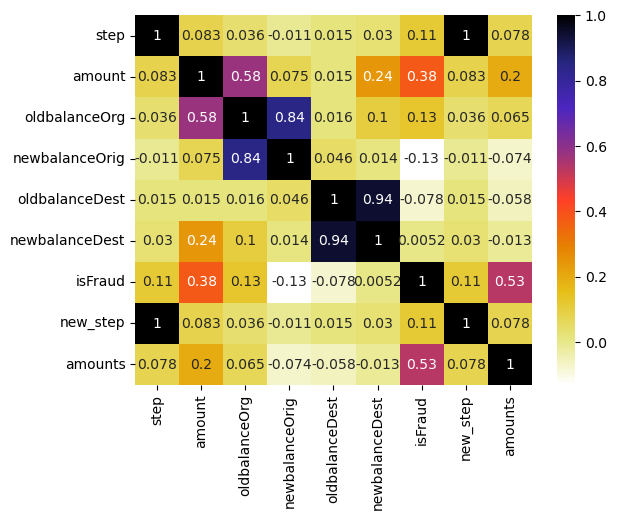

In [53]:
sns.heatmap(corrs,annot=True, cmap=plt.cm.CMRmap_r)

Here we have high correlation 84% between **oldbalanceOrg and newbalanceOrig**  and  94% correlation between  **oldbalanceDest and  newbalanceDest** 

In here we need to remove one feature, so we calculate the correlation to **isFraud**

                            step               11.332240
                            amount             37.794670
                            oldbalanceOrg      12.840274
                            newbalanceOrig    -13.140912
                            oldbalanceDest     -7.774510
                            newbalanceDest      0.522653
                            isFraud           100.000000
                            new_step           11.332240
                            amounts            53.419804
                            Name: isFraud, dtype: float64
- from this data, oldbalanceOrg  has high relation to 'isFraud' than newbalanceOrig. so drop the 'newbalanceOrig' feature       
- from this data, oldbalanceDest  has high relation to 'isFraud' than newbalanceDest. so drop the 'newbalanceDest' feature    

- from this data, new_step  has high relation to 'isFraud' than step. so drop the 'step' feature  
- from this data, amounts  has high relation to 'isFraud' than amount. so drop the 'amount' feature  

In [60]:
df4 = df3.copy()
df4 = df3.drop(['step','amount'],axis=1)

## 5. Preprocessing

### 5.1 One hot encording

In [61]:
df5 = df4.copy()
df5 = pd.get_dummies(df5, drop_first=True)

In [62]:
df6 = df5.copy()
df6 = df5.drop(['newbalanceOrig','oldbalanceDest'],axis=1)

### 5.2 Split the data train and test 

In [63]:
#independent features 
x1 = df6.drop(['isFraud'],axis=1)

# dependent features 
y1 = df6['isFraud']

In [64]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

In [65]:
x_resampled,y_resampled = rus.fit_resample(x1,y1)

In [66]:
x_train,x_test, y_train, y_test = train_test_split(x_resampled,y_resampled,test_size=0.3,random_state=42,
                                                  stratify=y_resampled,shuffle=True)


In [67]:
y_test.value_counts(normalize=True)*100

1    50.0
0    50.0
Name: isFraud, dtype: float64

In [68]:
y_train.value_counts(normalize=True)*100

1    50.0
0    50.0
Name: isFraud, dtype: float64

### 5.3  Standard scaling

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
scaler = StandardScaler()

## 6. Modeling 

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

In [73]:
from sklearn.metrics import precision_score,recall_score
from sklearn import metrics

In [74]:
models={'Logistic regression'     : LogisticRegression(),
        'Random forest classifier': RandomForestClassifier(),
        'Decision tree classifier': DecisionTreeClassifier(),
        'Support Vector Machines' : SVC(),
        'KNeighborsClassifier'    : KNeighborsClassifier()
       }

In [75]:
for name, model in models.items():
    ### construct a pipeline
    pipeline=Pipeline(steps=[
        ('scaling',scaler),
        ('Modeling',model)
    ])
    
    pipeline.fit(x_train,y_train)
    print(name+'___trained')
    
    
    

Logistic regression___trained
Random forest classifier___trained
Decision tree classifier___trained
Support Vector Machines___trained
KNeighborsClassifier___trained


In [91]:
for name, model in models.items():
    ### construct a pipeline
    pipeline=Pipeline(steps=[
        ('scaling',scaler),
        ('Modeling',model)
    ])
    

    y_predictions = pipeline.predict(x_test)
    print(name+'__accuracy score: {:.5f}'.format(accuracy_score(y_test,y_predictions)))  
    print(name+'__precision score: {:.5f}'.format(precision_score(y_test,y_predictions, average='weighted')))  
    print(name+'__recall_score:{:.5f}'.format(recall_score( y_test,y_predictions)))
    print(name+'__f1_score:{:.5f}'.format(f1_score(y_test,y_predictions)))
    print('-------------------------------------------------------------------')
    

Logistic regression__accuracy score: 0.88542
Logistic regression__precision score: 0.88604
Logistic regression__recall_score:0.86540
Logistic regression__f1_score:0.88308
-------------------------------------------------------------------
Random forest classifier__accuracy score: 0.95043
Random forest classifier__precision score: 0.95043
Random forest classifier__recall_score:0.94879
Random forest classifier__f1_score:0.95035
-------------------------------------------------------------------
Decision tree classifier__accuracy score: 0.93204
Decision tree classifier__precision score: 0.93210
Decision tree classifier__recall_score:0.92646
Decision tree classifier__f1_score:0.93166
-------------------------------------------------------------------
Support Vector Machines__accuracy score: 0.91202
Support Vector Machines__precision score: 0.91486
Support Vector Machines__recall_score:0.87065
Support Vector Machines__f1_score:0.90822
--------------------------------------------------------

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


from these model **Random forest classifier** has good score than other classifer model, so we select Random forest classifer

### 6.1  Plot the confusin model 

In [241]:
## predict and plot confusion metrix 

In [92]:
rand_clas = RandomForestClassifier()

In [93]:
rand_clas.fit(x_train,y_train)

RandomForestClassifier()

In [94]:
y_predictions = rand_clas.predict(x_test)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


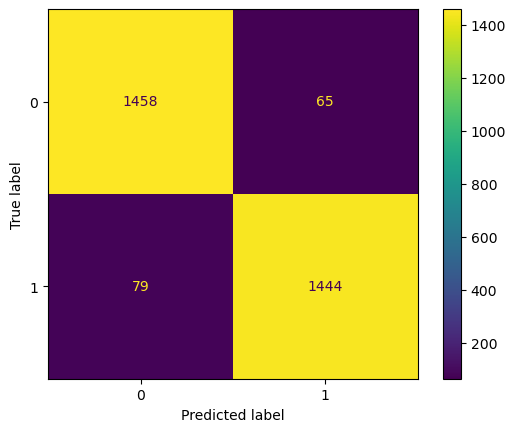

In [95]:
plot_confusion_matrix(rand_clas,x_test,y_test,)

The accuracy score for the **random forest classifier** is 0.95043, which means that the model correctly **predicted 95.043%** of the samples in the test set. The **precision score is also 0.95043**, which indicates that the model has a high precision, meaning that it has a low false positive rate. The **recall score is 0.94879**, indicating that the model has a high recall, meaning that it has a low false negative rate. The **F1 score is 0.95035**, and it is a good measure of a model's balance between precision and recall. In general, these scores suggest that the random forest classifier is performing well on the dataset.

## 7. Hypertuning the parameters

In [98]:
from sklearn.model_selection import cross_val_score

In [101]:
np.mean(cross_val_score(RandomForestClassifier(max_samples=0.75,random_state=42),x_train,y_train,cv=10))

0.9556698559854201

### 7.1 Gridsearch CV

In [190]:
## Number of tress in random forest
n_estimators = [20,40,80,100,120]

## Number of featues to consider at every split
max_features = [0.1,0.2,0.4,0.6,0.8]

## Max number of level in tree
max_depth = [2,6,8,None]

## Number of sample
max_samples = [0.6,0.65,0.7,0.75,0.8,0.1]

# 600 diff random forest train

In [191]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth'   : max_depth,
              'max_samples' : max_samples
             }
print(param_grid)

{'n_estimators': [20, 40, 80, 100, 120], 'max_features': [0.1, 0.2, 0.4, 0.6, 0.8], 'max_depth': [2, 6, 8, None], 'max_samples': [0.6, 0.65, 0.7, 0.75, 0.8, 0.1]}


In [192]:
from sklearn.model_selection import GridSearchCV

rf_grid_cv = GridSearchCV(estimator = rand_clas,
                         param_grid = param_grid,
                         cv = 5,
                         verbose = 2,
                         n_jobs = -1)

In [193]:
rf_grid_cv.fit(x_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 6, 8, None],
                         'max_features': [0.1, 0.2, 0.4, 0.6, 0.8],
                         'max_samples': [0.6, 0.65, 0.7, 0.75, 0.8, 0.1],
                         'n_estimators': [20, 40, 80, 100, 120]},
             verbose=2)

In [194]:
rf_grid_cv.best_params_

{'max_depth': None,
 'max_features': 0.1,
 'max_samples': 0.6,
 'n_estimators': 80}

In [195]:
rf_grid_cv.best_score_

0.958767176301628

## Final model

In [201]:
random_class = RandomForestClassifier(n_estimators=80,
                                      max_depth=None,
                                      max_features=0.1,
                                      max_samples=0.6)                                         

In [202]:
random_class.fit(x_train,y_train)

RandomForestClassifier(max_features=0.1, max_samples=0.6, n_estimators=80)

In [203]:
y_predictions_final = random_class.predict(x_test)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


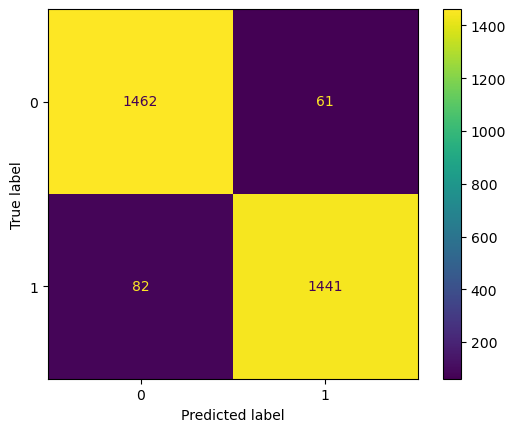

In [204]:
plot_confusion_matrix(random_class,x_test,y_test,)

In [242]:

print('random_forest_classifer'+'__accuracy score: {:.5f}'.format(accuracy_score(y_test,y_predictions_final)))  
print('random_forest_classifer'+'__precision score: {:.5f}'.format(precision_score(y_test,y_predictions_final)))  
print('random_forest_classifer'+'__recall_score:{:.5f}'.format(recall_score( y_test,y_predictions_final)))
print('random_forest_classifer'+'__f1_score:{:.5f}'.format(f1_score(y_test,y_predictions_final)))

random_forest_classifer__accuracy score: 0.95305
random_forest_classifer__precision score: 0.95939
random_forest_classifer__recall_score:0.94616
random_forest_classifer__f1_score:0.95273


## 8 Save  and Load Model

In [207]:
import pickle

In [212]:
# save the model
with open('random_forest_class_model1','wb') as model:
    pickle.dump(random_class, model)

In [213]:
# Load the model
with open('random_forest_class_model1', 'rb') as model:
    rf_model = pickle.load(model)

In [235]:

data = x_test.iloc[[125]]

In [236]:
data

,oldbalanceOrg,newbalanceDest,new_step,amounts,namestart_M,new_type_REPLACE,new_type_TRANSFER
1332,0.0,2440391.1,140,262120.5,0,0,1


In [237]:
y_test.iloc[125]

0

In [238]:
rf_model.predict(data)[0] 
# we got the result right

0

## 9 About Model

### 9.1 Describing my model

The fraud detection model that I am describing is a Random Forest Classifier, which is a type of ensemble learning method that combines multiple decision trees to create a more accurate and stable model.

The first step is to finding there is any missing value present in the data set. In this data there is no missing values are present. Then clean the data by perfoming outler calculation . in here there is high outlier on amount column. so clean outlier on amount colum. Then drop the unwanted column.


Once the data is prepared, the next step is to train the model. This involves using the prepared data to train various classifer algorithums. then calculate the accuracy score, recall score, precision score and F1 score. based on scores we select high perfoming algorithm. Here **random forest classifier**.  The model is then fine-tuned using various techniques such as cross-validation and grid search to optimize the performance.

Once the model is trained, it can be used to make predictions on new data(test data set). The model will take in the new data and use the trained mdoel to make a prediction about whether the transaction is fraudulent or not. It will also output a probability of the transaction being fraudulent.  

The Random Forest Classifier is a powerful and flexible model that can be used for fraud detection. It is able to handle large amounts of data, handle non-linear relationships between features. Furthermore, it is less prone to overfitting than a single decision tree.

It's important to note that the performance of the model will depend on the quality and relevance of the data and features used to train it, so it's important to continuously monitor the model's performance and fine-tune it as necessary.

### 9.2 What are the key factors that predict fraudulent customer?


Most common factors that are often used to identify fraudulent activity include:

- Anomalous behavior: This can include unusual spending patterns, large or unexpected transactions, or transactions that deviate from a customer's normal behavior,high amount transaction activity.

- Suspicious account activity: This can include a sudden change in account information, multiple failed login attempts, or the use of multiple devices or IP addresses to access the same account.


In addition to these factors, other information such as IP address, location, and device information can also be used to identify fraud.

It's important to note that these are not definitive indicators of fraud, and a combination of factors should be used to make a decision. Fraud detection models such as Random Forest classifier can be trained using these factors to classify fraudulent customers more precisely.

### 9.3 What kind of prevention should be adopted while company update its infrastructure?

It is important to implement a variety of security measures to prevent unauthorized access and other types of security incidents. Some steps that can be taken to prevent security issues during infrastructure updates include:


- **Data encryption:**  Encrypt sensitive data to protect it from unauthorized access. 

- **Data validation:**  Implement data validation mechanisms to ensure that the data used for fraud detection is accurate and complete.

- **Regular monitoring:** Regularly monitor the infrastructure to detect and respond to security incidents as soon as they occur.

- **Keeping software up-to-date:** Keep all software and applications up-to-date with the latest security patches and updates to prevent known vulnerabilities from being exploited.

- **Keep update the model** 

- **Conducting regular security assessments:** it is important to conduct regular security assessments to identify potential vulnerabilities and risks.


        
        
        
        